In [10]:
import numpy as np
import scipy.ndimage as ndi

In [11]:
C, H, W = (2, 4, 4)
im = np.arange(1, W*H*C+1)
im = np.reshape(im, (C, H, W))

K = 3
k = np.arange(1, K*K*C+1)
k = np.reshape(k, (C, K, K))

In [12]:
for c, im_c in enumerate(im):
    print(f'im[{c}, :, :] =\n{im_c}\n')

for c, k_c in enumerate(k):
    print(f'k[{c}, :, :] =\n{k_c}\n')

im[0, :, :] =
[[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]
 [13 14 15 16]]

im[1, :, :] =
[[17 18 19 20]
 [21 22 23 24]
 [25 26 27 28]
 [29 30 31 32]]

k[0, :, :] =
[[1 2 3]
 [4 5 6]
 [7 8 9]]

k[1, :, :] =
[[10 11 12]
 [13 14 15]
 [16 17 18]]



In [ ]:
# calculate ground truth
gt = ndi.convolve(im, k, mode='constant', cval=0)
print(gt.shape)
print(gt)

(2, 4, 4)
[[[ 376  676  772  604]
  [ 927 1590 1761 1329]
  [1359 2274 2445 1809]
  [1324 2164 2296 1664]]

 [[ 923 1478 1553 1105]
  [1692 2694 2820 1995]
  [2016 3198 3324 2343]
  [1637 2582 2675 1875]]]


In [ ]:
def im2col(im, C, H, W, K):
    H_out = H - K + 1
    W_out = W - K + 1

    # process everything in im, consider it as padded smem
    im = im.ravel()

    col = np.zeros((H_out*W_out) * (K*K*C))
    for c in range(C):
        for h in range(H_out):
            for w in range(W_out):
                for q in range(K):
                    for p in range(K):
                        dst = (h * (W_out) + w) * (K*K*C) + (c * (K*K) + q * (K) + p)
                        src = c * (H*W) + (h+q) * (W) + (w+p)
                        col[dst] = im[src]
    col = np.reshape(col, (H_out*W_out, K*K*C))
    return col

In [ ]:
col = im2col(im, C, H, W, K)

In [ ]:
print(f'col=\n{col}\n')
print(f'k.ravel=\n{k.ravel()}\n')

col=
[[ 1.  2.  3.  5.  6.  7.  9. 10. 11. 17. 18. 19. 21. 22. 23. 25. 26. 27.]
 [ 2.  3.  4.  6.  7.  8. 10. 11. 12. 18. 19. 20. 22. 23. 24. 26. 27. 28.]
 [ 5.  6.  7.  9. 10. 11. 13. 14. 15. 21. 22. 23. 25. 26. 27. 29. 30. 31.]
 [ 6.  7.  8. 10. 11. 12. 14. 15. 16. 22. 23. 24. 26. 27. 28. 30. 31. 32.]]

k.ravel=
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]



In [ ]:
out = col @ k.ravel()

In [ ]:
print(out)

[356. 392. 464. 500.]


In [8]:
from math import ceil, floor
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from collections import namedtuple
dim3 = namedtuple('dim3', ['x', 'y'])

In [72]:
if True:
    # op 1
    H = 86
    W = 86
    K = 7
    C = 1
    M = 4
else:
    # op 2
    H = 40
    W = 40
    K = 7
    C = 4
    M = 16

# build input
x = np.empty((C, H, W))

H_out = H - K + 1
W_out = W - K + 1
print(f'H_out={H_out}, W_out={W_out}')

H_out=80, W_out=80


In [73]:
TILE_WIDTH = 8
PADDED_TILE_WIDTH = TILE_WIDTH + K - 1

HW_TILE_WIDTH = TILE_WIDTH * TILE_WIDTH
M_TILE_WIDTH = 4
CKK_TILE_WIDTH = 16

thread_dim = dim3(HW_TILE_WIDTH, M_TILE_WIDTH)
block_dim = dim3(ceil(H_out / TILE_WIDTH) * ceil(W_out / TILE_WIDTH), ceil(M / M_TILE_WIDTH))

print(f'block_dim={block_dim}, thread_dim={thread_dim}')

block_dim=dim3(x=100, y=1), thread_dim=dim3(x=64, y=4)


In [74]:
B_BATCH = 2
C_MAX = 4

smem_size = B_BATCH * ((HW_TILE_WIDTH + M_TILE_WIDTH) * CKK_TILE_WIDTH + C_MAX * PADDED_TILE_WIDTH * PADDED_TILE_WIDTH) * 4
print(f'{smem_size / 1024} KiB')

14.625 KiB


In [75]:
def kernel(block_index, block_dim, thread_index, thread_dim, tile_x, y):
    print(f'block={block_index}, thread={thread_index}')

    t_hw = thread_index.x
    b_hw = HW_TILE_WIDTH
    
    t_m = thread_index.y
    b_m = M_TILE_WIDTH
    m = block_index.y * b_m + t_m
    
    ib_hw = block_index.x
    nb_w = ceil(W_out / TILE_WIDTH)

    ib_w = ib_hw % nb_w
    ib_h = floor(ib_hw / nb_w)
    
    # use every threads to help loading to smem
    i = t_m * HW_TILE_WIDTH + t_hw
    t_w = i % TILE_WIDTH
    t_h = int(i / TILE_WIDTH)

    # revert back to original indexing
    t_w = t_hw % TILE_WIDTH
    t_h = int(t_hw / TILE_WIDTH)

    dst_w = ib_w * TILE_WIDTH + t_w
    dst_h = ib_h * TILE_WIDTH + t_h
    dst_hw = dst_h * W_out + dst_w

    print(f'.. in 2D, block={(ib_w, ib_h)}, thread={(t_w, t_h)}')
    print(f'.. in 1D, dst_hw={dst_hw}')

    n_kernel = C * K * K
    n_tiles = ceil(n_kernel / CKK_TILE_WIDTH)

    for c in range(C):
        dst = i
        while dst < PADDED_TILE_WIDTH * PADDED_TILE_WIDTH:
            t_pw = dst % PADDED_TILE_WIDTH
            t_ph = floor(dst / PADDED_TILE_WIDTH)

            src_w = ib_w * TILE_WIDTH + t_pw
            src_h = ib_h * TILE_WIDTH + t_ph

            if ((src_w < W) and (src_h < H)):
                tile_x[c][t_ph][t_pw] = x[c][src_h][src_w]
            else:
                tile_x[c][t_ph][t_pw] = 0
            
            dst += TILE_WIDTH * TILE_WIDTH

    print(f'.. m={m}, dst_w/h=({dst_w}, {dst_h})')
    if (m < M) and (dst_w < W_out) and (dst_h < H_out):
        if (y[m][dst_hw] == 1):
            raise RuntimeError('.. overwrite!')
        y[m][dst_hw] = 1
    else:
        pass
        #raise RuntimeError('.. DEBUG, no writeback')

    """
    assert m < M, f'm={m}, oob'
    assert dst_w < W_out, f'W_out={W_out}, oob'
    assert dst_h < H_out, f'H_out={H_out}, oob'
    """

In [76]:
y = np.zeros((M, H_out * W_out))

# iterate in grid
for by in range(block_dim.y):
    for bx in range(block_dim.x):
        # iterate in block

        # shared memory
        tile_x = np.zeros((4, PADDED_TILE_WIDTH, PADDED_TILE_WIDTH+1))

        for ty in range(thread_dim.y):
            for tx in range(thread_dim.x):
                kernel(dim3(bx, by), block_dim, dim3(tx, ty), thread_dim, tile_x, y)

Streaming output truncated to the last 5000 lines.
block=dim3(x=95, y=0), thread=dim3(x=30, y=0)
.. in 2D, block=(5, 9), thread=(6, 3)
.. in 1D, dst_hw=6046
.. m=0, dst_w/h=(46, 75)
block=dim3(x=95, y=0), thread=dim3(x=31, y=0)
.. in 2D, block=(5, 9), thread=(7, 3)
.. in 1D, dst_hw=6047
.. m=0, dst_w/h=(47, 75)
block=dim3(x=95, y=0), thread=dim3(x=32, y=0)
.. in 2D, block=(5, 9), thread=(0, 4)
.. in 1D, dst_hw=6120
.. m=0, dst_w/h=(40, 76)
block=dim3(x=95, y=0), thread=dim3(x=33, y=0)
.. in 2D, block=(5, 9), thread=(1, 4)
.. in 1D, dst_hw=6121
.. m=0, dst_w/h=(41, 76)
block=dim3(x=95, y=0), thread=dim3(x=34, y=0)
.. in 2D, block=(5, 9), thread=(2, 4)
.. in 1D, dst_hw=6122
.. m=0, dst_w/h=(42, 76)
block=dim3(x=95, y=0), thread=dim3(x=35, y=0)
.. in 2D, block=(5, 9), thread=(3, 4)
.. in 1D, dst_hw=6123
.. m=0, dst_w/h=(43, 76)
block=dim3(x=95, y=0), thread=dim3(x=36, y=0)
.. in 2D, block=(5, 9), thread=(4, 4)
.. in 1D, dst_hw=6124
.. m=0, dst_w/h=(44, 76)
block=dim3(x=95, y=0), thread=di

In [77]:
# quick check for unwritten cells
for y_m in y:
    assert np.count_nonzero(y_m) == H_out * W_out

(16, 1156)


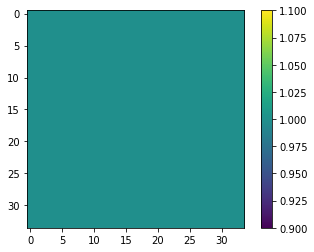

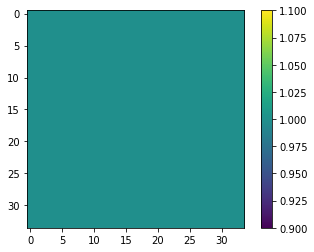

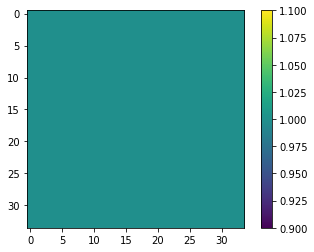

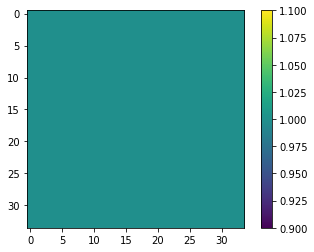

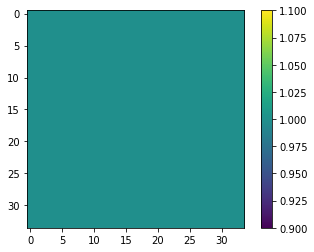

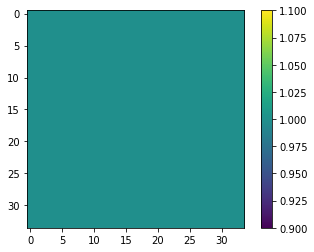

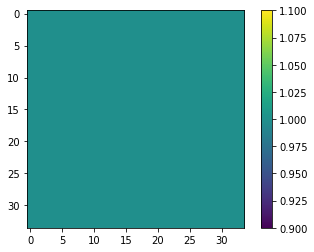

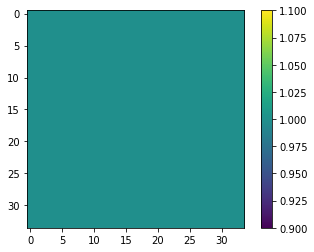

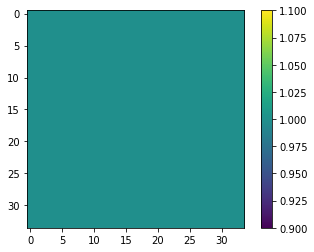

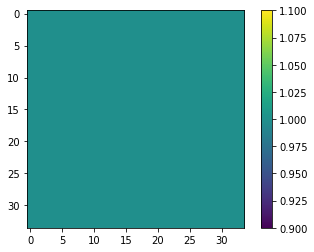

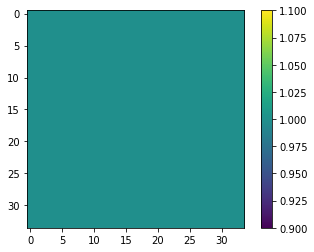

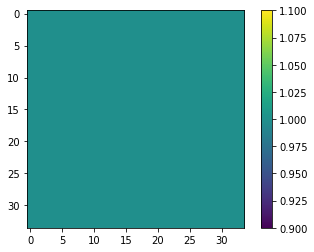

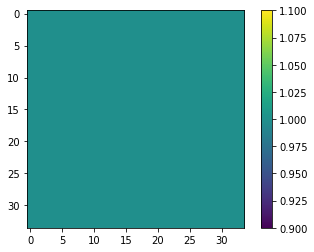

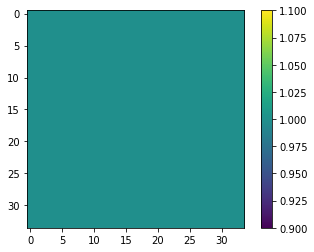

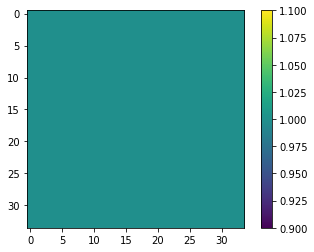

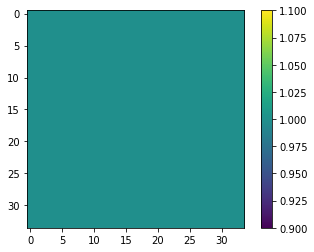

In [71]:
# find out unwritten cells
print(y.shape)
for y_m in y:
    plt.figure()
    plt.imshow(np.reshape(y_m, (-1, W_out)))
    plt.colorbar()